In [1]:
import IPython as ipd
import librosa
from utils import *

import torch
import torch.nn
import torch.optim
from torch.utils.data import IterableDataset

import os
import timeit
from time import time

import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"

print(f"USING DEVICE {DEVICE}")

USING DEVICE cuda


In [3]:
# Define source paths. Place data under working directory and name folder "voicedata"
DATA_DIR = "./commands"
TARGET_RATE = 8000
INPUT_SIZE = 64
EPOCHS = 10
os.makedirs(DATA_DIR, exist_ok=True)
train_set = SpeechCommandsSubset(root=DATA_DIR, download=True, rate=TARGET_RATE)
test_set = SpeechCommandsSubset(root=DATA_DIR, download=True, subset="testing", rate=TARGET_RATE)
validate_set = SpeechCommandsSubset(root=DATA_DIR, download=True, subset="validation", rate=TARGET_RATE)

# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = train_set.labels

print(f'  Training Set: {len(train_set)}')
print(f'   Testing Set: {len(test_set)}')
print(f'Validation Set: {len(validate_set)}')

print(f'   Data Labels: {len(labels)}')

  Training Set: 84843
   Testing Set: 11005
Validation Set: 9981
   Data Labels: 35


# Preview sample 52000

In [4]:
waveform, rate, label, speaker, id = train_set[52000]
print(f"Label: {label} ({label_to_index(label, labels)})")
print(rate)
print(waveform.size())
ipd.display.Audio(data=waveform, rate=rate)

Label: right (22)
8000
torch.Size([1, 8000])


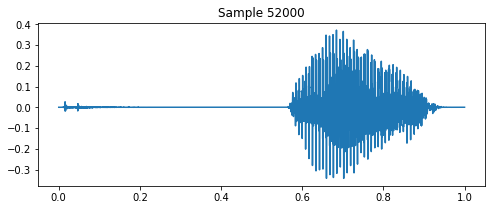

In [5]:
Y = waveform.view(-1).numpy()
times = np.linspace(0, len(Y) / rate, len(Y))
plot(times, Y, title="Sample 52000")

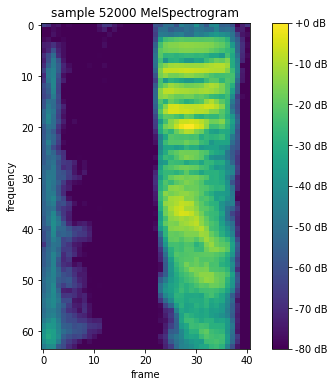

In [6]:
mel = torchaudio.transforms.MelSpectrogram(sample_rate=TARGET_RATE, n_mels=INPUT_SIZE)
melspec = mel(waveform).squeeze()
plot_mel(melspec, title="sample 52000 MelSpectrogram", figsize=(8,6))

torch.Size([1, 64, 32])


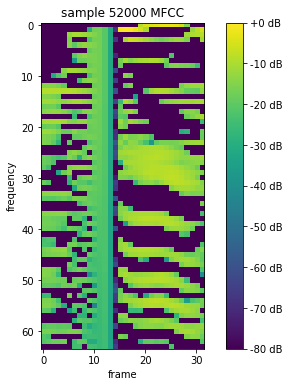

In [7]:
mfcc = torchaudio.transforms.MFCC(
    sample_rate=TARGET_RATE, 
    n_mfcc=INPUT_SIZE,
    melkwargs={
        "n_fft": 2048,
        "n_mels": 128,
        "hop_length": 256,
        "mel_scale": "htk",
    },
)
mfccspec = mfcc(waveform)
plot_mel(mfccspec.squeeze(), title="sample 52000 MFCC", figsize=(8,6))
print(mfccspec.shape)

In [8]:
train_set = SpeechCommandsSubset(
    root=DATA_DIR,
    download=True,
    rate=TARGET_RATE,
    feature=mfcc
)
test_set = SpeechCommandsSubset(
    root=DATA_DIR,
    download=True,
    subset="testing",
    rate=TARGET_RATE,
    feature=mfcc
)
validate_set = SpeechCommandsSubset(
    root=DATA_DIR,
    download=True,
    subset="validation",
    rate=TARGET_RATE,
    feature=mfcc
)

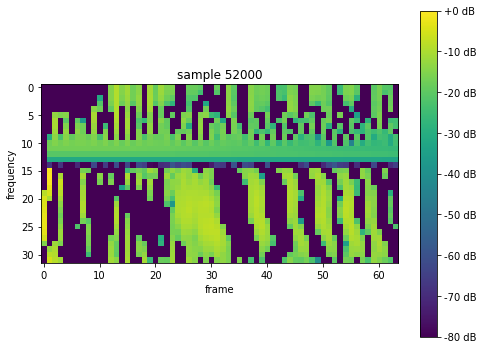

In [9]:
sample, rate, label, speaker, id = train_set[52000]
plot_mel(sample.squeeze(), title="sample 52000", figsize=(8,6))

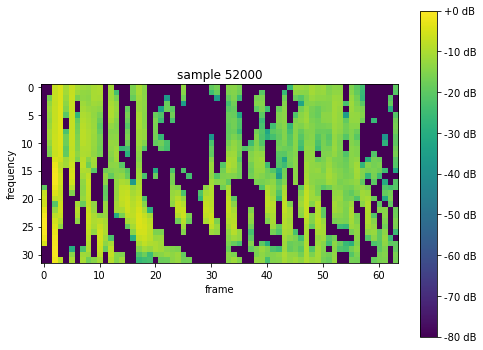

In [10]:
sample, rate, label, speaker, id = test_set[1000]
plot_mel(sample.squeeze(), title="sample 52000", figsize=(8,6))

# Define and run the model

In [11]:
def plot_results(CATEGORY, cat_title, time_data, loss_data, accuracy_data):
    fig, ax = plt.subplots(3, 1, figsize=(10,16))
    plot(CATEGORY, time_data, ax=ax[0])
    ax[0].set_xlabel(cat_title)
    ax[0].set_xticks(CATEGORY)
    ax[0].grid(True)
    ax[0].set_ylabel("time to run")
    ax[0].set_title(f"time to run for each {cat_title}")

    for l in loss_data:
        plot(list(range(DEF_EPOCHS)), l, ax=ax[1])
    ax[1].legend(CATEGORY)
    ax[1].set_xlabel("epoch")
    ax[1].grid(True)
    ax[1].set_ylabel("loss")
    ax[1].set_title(f"Loss curves for {cat_title}")

    plot(CATEGORY, accuracy_data, ax=ax[2])
    ax[2].set_xlabel(cat_title)
    ax[2].set_xticks(CATEGORY)
    ax[2].grid(True)
    ax[2].set_ylabel("accuracy")
    ax[2].set_title(f"Accuracy over {cat_title}")

    pass


In [12]:
class ImprovedRNNCell(RNNCell):
    '''
    Simple RNN with weighted residual connection.
    '''

    def __init__(self, input_size, hidden_size,
                 update_nonlinearity="tanh",
                 name="ImprovedRNN"):
        super(ImprovedRNNCell, self).__init__(input_size, hidden_size,
                                           None, update_nonlinearity,
                                           1, 1, 1, 0, 0, 0, 0)
        # TODO: Initialize all the required variables
        
        # Reduce W and U starting values to a small fraction.
        self.rnn = torch.nn.RNN(
            input_size, 
            hidden_size, 
            nonlinearity=update_nonlinearity,
            batch_first=True
        )
        self._name = name

    @property
    def name(self):
        return self._name

    @property
    def cellType(self):
        return "RNN"

    def forward(self, input, state):  
        return self.rnn(input, state)

In [13]:
BATCH_SIZE = 24
LEARNING_RATE = 0.005
NON_LINEARITY = "tanh"
PERFORMANCE_MODE = False
DEBUG_MODE = False

def initialize_model(input_size, hidden_size, non_linearity=NON_LINEARITY, fn=None, learning_rate=LEARNING_RATE):
    model = ImprovedRNNCell(input_size, hidden_size, update_nonlinearity=non_linearity)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if not fn:
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        loss_fn = fn

    return model, optimizer, loss_fn

def train_model(model, optimizer, loss_fn, train_data, labels, batch_size=BATCH_SIZE, epochs=1, cap=None):
    # Initialize model
    model.train()

    hidden = torch.zeros(1, batch_size, len(labels))
    hidden = hidden.to(DEVICE)
    loss_summary = 0
    data_size = 0
    losses = []
    micro_times = {
        "init": 0,
        "model": 0,
        "lossfn": 0,
        "backward": 0,
        "optimizer": 0,
        "total": 0
    }

    num_workers = 0 if DEVICE=="cpu" else 4
    pin_memory = False if DEVICE=="cpu" else True

    data_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    for e in range(epochs):
        print(f"=> [{e}] ", end="")

        diverged = False
        count = 0.0
        for waveform, rate, label, speaker, id in data_loader:
            beggining = time()

            if cap and count > cap:
                break
            count += 1
            if waveform.shape[0] != batch_size:
                continue

            optimizer.zero_grad()
            target = torch.tensor([label_to_index(x, labels) for x in label])

            waveform = waveform.squeeze(1)
            waveform = waveform.to(DEVICE)
            target = target.squeeze(0)
            target = target.to(DEVICE)
            batch_len = waveform.shape[0]

            starting = time()

            output, hidden_next = model(waveform, hidden)
            output = output.sum(dim=1)

            model_done_time = time()
            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item() * batch_len
            data_size += batch_len

            if not diverged and loss.item() != loss.item():
                print("DIVERGED at ", count)
                diverged = True
                if DEBUG_MODE:
                    print("output:", torch.max(output).item())
                    print("target:", target)
                    print("hidden:", hidden)
                    print("hidden:", hidden_next)
                    print("  loss:", loss.item)
                break
                
            loss_done_time = time()
            loss.backward()
            backward_done_time = time()
            optimizer.step()
            optimizer_done_time = time()
            hidden = hidden_next.detach()
            #hidden = torch.zeros(1, len(labels)).to(DEVICE)

            final_time = time()
            
            micro_times["init"] += starting - beggining
            micro_times["model"] += model_done_time - starting
            micro_times["lossfn"] += loss_done_time - model_done_time
            micro_times["backward"] += backward_done_time - loss_done_time
            micro_times["optimizer"] += optimizer_done_time - backward_done_time
            micro_times["total"] += final_time - beggining

        # print("loss:", loss_summary)
        losses.append(loss_summary / data_size)
    print("finished...")
    if PERFORMANCE_MODE:
        print(f"init: {micro_times['init']:.3f} seconds")
        print(f"model: {micro_times['model']:.3f} seconds")
        print(f"lossfn: {micro_times['lossfn']:.3f} seconds")
        print(f"backward: {micro_times['backward']:.3f} seconds")
        print(f"optimizer: {micro_times['optimizer']:.3f} seconds")
        print(f"train time: {micro_times['total']:.3f} seconds")
    return losses


In [14]:
m, o, l = initialize_model(INPUT_SIZE, len(labels), learning_rate=0.05)
def test_model(model, opt, lossfn):
    loss = train_model(model, opt, lossfn, train_set, labels, epochs=5, cap=20)
    print(loss)
    # train_model(model, opt, lossfn, train_set, labels, EPOCHS)

PERFORMANCE_MODE = True
result = timeit.timeit(stmt='test_model(m, o, l)', globals=globals(), number = 1)
PERFORMANCE_MODE = False
print(f"time result: {result} seconds")

=> [0] => [1] => [2] => [3] => [4] finished...
init: 0.039 seconds
model: 0.061 seconds
lossfn: 0.014 seconds
backward: 0.078 seconds
optimizer: 0.039 seconds
train time: 0.233 seconds
[19.99553074155535, 15.115434987204415, 12.384351976334102, 10.490512019111996, 9.36503519330706]
time result: 1.5372117970255204 seconds


In [15]:
m, o, l = initialize_model(INPUT_SIZE, len(labels), learning_rate=0.05)
def test_model(model, opt, lossfn):
    loss = train_model(model, opt, lossfn, train_set, labels, epochs=2, cap=None)
    print(loss)
    # train_model(model, opt, lossfn, train_set, labels, EPOCHS)

PERFORMANCE_MODE = True
result = timeit.timeit(stmt='test_model(m, o, l)', globals=globals(), number = 1)
PERFORMANCE_MODE = False
print(f"time result: {result} seconds")

=> [0] => [1] finished...
init: 2.426 seconds
model: 3.787 seconds
lossfn: 0.897 seconds
backward: 5.099 seconds
optimizer: 3.111 seconds
train time: 15.388 seconds
[4.278400248955129, 4.087265914096859]
time result: 56.0996488549863 seconds


In [77]:
def eval_model(model, loss_fn, test_data, labels, cap=3, batch_size = 1):
    with torch.no_grad():
        model.eval()
        loss_summary = 0
        data_size = 0
        attempts = 0
        hits = 0

        hidden = torch.zeros(1, 1, len(labels))
        hidden = hidden.to(DEVICE)

        num_workers = 0 if DEVICE=="cpu" else 4
        pin_memory = False if DEVICE=="cpu" else True
        
        data_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

        count = 0
        for waveform, rate, label, speaker, id in data_loader:
            if cap and count > cap:
                break
            count += 1
            if waveform.shape[0] != batch_size:
                continue

            # send data to target device
            waveform = waveform.squeeze(1)
            waveform = waveform.to(DEVICE)
            target = torch.tensor([label_to_index(x, labels) for x in label])
            target = target.to(DEVICE)
            batch_len = waveform.shape[0]

            # Predict, calculate loss, calculate gradients
            output, hidden_next = model(waveform, hidden)

            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item()
            data_size += 1

            hidden = hidden_next.detach()
            
            prediction = torch.argmax(output.view(batch_len, -1), dim=1)
            hits += prediction[prediction == target].shape[0]
            attempts += 1
            # print(prediction == target)
            # print(prediction[prediction == target])
        print(data_size)
        loss_summary = loss_summary / data_size
        return model, loss_summary, attempts, hits

In [79]:
# Run a 5 epoch test on the whole data set to collect performance numbers on model
losses = []
times = []
accuracies = []
correct = []

def timed_test(rate=INPUT_SIZE, nl=NON_LINEARITY, fn=None, lr=0.005, cap=5, ep=5, batch=16, ts=train_set, tst=test_set):
    m, o, l = initialize_model(rate, len(labels), non_linearity=nl, fn=fn, learning_rate=lr)
    start_time = time()
    losses.append(train_model(m, o, l, ts, labels, epochs=ep, cap=cap, batch_size=24))
    result = time() - start_time
    times.append(result)
    
    m, loss, attempts, hits = eval_model(m, l, tst, labels, cap=cap, batch_size=1)
    accuracies.append(hits/attempts)
    correct.append(hits)
    
PERFORMANCE_MODE = True
timed_test(nl="tanh", fn=torch.nn.CrossEntropyLoss(), lr=0.005, cap=None, ep=5, batch=24)
PERFORMANCE_MODE = False
print(losses)
print(times)
print(accuracies)
print(correct)

=> [0] => [1] => [2] => [3] => [4] finished...
init: 6.614 seconds
model: 10.480 seconds
lossfn: 2.432 seconds
backward: 13.785 seconds
optimizer: 8.075 seconds
train time: 41.563 seconds
11005
[[4.0629006328474855, 3.7841235638339246, 3.686606392395041, 3.630905904628263, 3.5965718058109957]]
[143.28029108047485]
[0.015174920490686052]
[167]


In [80]:
DEF_CAP=None
DEF_EPOCHS=10

In [81]:
losses = []
times = []
accuracies = []
correct = []

BATCHES = [1, 8, 16, 24, 48]
for b in BATCHES:
    print(f"== Training with {b} samples per batch")
    timed_test(nl="tanh", fn=torch.nn.CrossEntropyLoss(), lr=0.005, cap=DEF_CAP, ep=DEF_EPOCHS, batch=b)

== Training with 1 samples per batch
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] finished...
11005
== Training with 8 samples per batch
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] finished...
11005
== Training with 16 samples per batch
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] finished...
11005
== Training with 24 samples per batch
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] finished...
11005
== Training with 48 samples per batch
=> [0] => [1] => [2] => [3] => [4] => [5] => [6] => [7] => [8] => [9] finished...
11005


In [82]:
for t, b in zip (times, BATCHES):
    print(f"{b} batch: time taken = {t:.3f} seconds")

for l, b in zip (losses, BATCHES):
    print(f"{b} batch: final loss = {l[-1]}")

for a, b in zip (accuracies, BATCHES):
    print(f"{b} batch: accuracy = {a*100:.3f}%")

1 batch: time taken = 292.495 seconds
8 batch: time taken = 288.462 seconds
16 batch: time taken = 289.989 seconds
24 batch: time taken = 287.220 seconds
48 batch: time taken = 285.421 seconds
1 batch: final loss = 3.500224050072666
8 batch: final loss = 3.5044865201925792
16 batch: final loss = 3.5208801197769617
24 batch: final loss = 3.4984566583323176
48 batch: final loss = 3.506333531389142
1 batch: accuracy = 1.517%
8 batch: accuracy = 1.508%
16 batch: accuracy = 1.545%
24 batch: accuracy = 1.517%
48 batch: accuracy = 1.490%


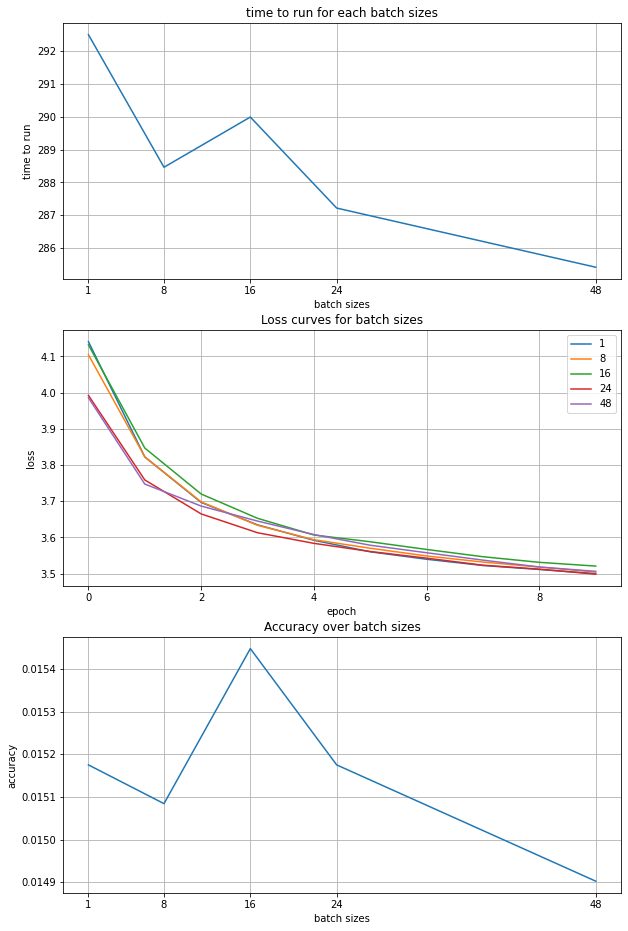

In [83]:
plot_results(BATCHES, "batch sizes", times, losses, accuracies)